# Predicting Pet Insurance Claims - EDA

## 1 Introduction

### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future. 

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy. 

### 1.3 Initial Questions for EDA
Below are a few initial questions to answer and areas of interest for the detailed data analysis.
* What patterns or relationships exist between 'Breed' and amounts claimed?
* What patterns or relationships exist between 'Species' and amounts claimed?
* Decide what to do about the very high (claims > \\$10k) and very low (claims = \$0) claims amounts
* Determine if EnrollPath is worth keeping or if there is any correlation between EnrollPath and claims amounts
* Look for connection between PetAge and number/amount of claims

Some opportunities for additional feature engineering:
* Scrape web and/or find data set for dog breed average weights to include as a new column
* Scrape web and/or find data set for average lifespan by breed and merge in as a new column
    * Create new feature for PctLifespanYr1 and PctLifeSpanYr2 to calculate pet age in year 1 and year 2 as a percentage of the average lifespan based on the breed
    * If above steps are completed, consider encoding breed, based on AvgWeight and AvgLifespan, into a new feature as a means of converting Breed from an object column to a numeric column

# 2 Setup

## 2.1 Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 2.2 Data Load & Preview

In [2]:
# Read in the data file generated during data wrangling
df = pd.read_csv('../data/merged_pets.csv', index_col='PetId')

# Preview
df.head()

,Species,Breed,Premium,Deductible,EnrollPath,AgeYr1,AgeYr2,YoungAge,MixedBreed,AmtClaimsYr1,AmtClaimsYr2,AvgClaimsYr1,AvgClaimsYr2,NumClaimsYr1,NumClaimsYr2,NumClaimsTotal,AmtClaimsTotal,AvgClaimsTotal
PetId,,,,,,,,,,,,,,,,,,
0,Dog,Schnauzer Standard,84.54,200,Web,3,4,0,0,0.00,1242.00,0.000000,621.000,0,2,2,1242.00,621.00000
1,Dog,Yorkiepoo,50.33,500,Phone,0,1,0,0,0.00,0.00,0.000000,0.000,0,0,0,0.00,0.00000
2,Dog,Mixed Breed Medium,74.00,500,Phone,0,1,0,1,640.63,1187.68,213.543333,237.536,3,5,8,1828.31,228.53875
3,Dog,Labrador Retriever,57.54,500,Phone,0,1,0,0,0.00,0.00,0.000000,0.000,0,0,0,0.00,0.00000
4,Dog,French Bulldog,60.69,700,Web,0,1,0,0,7212.25,168.75,801.361111,168.750,9,1,10,7381.00,738.10000


# 3 Species and Breed

## 3.1 Species Analysis
As a starting point, let's look at a breakdown of the data by species to see if we see any significant differences in our other data points when viewed through the species lens.

Is there a significant difference in claims amounts between cats and dogs?

In [3]:
# Group df by 'Species' and view column means
df.groupby(by='Species').agg('mean')

,Premium,Deductible,AgeYr1,AgeYr2,YoungAge,MixedBreed,AmtClaimsYr1,AmtClaimsYr2,AvgClaimsYr1,AvgClaimsYr2,NumClaimsYr1,NumClaimsYr2,NumClaimsTotal,AmtClaimsTotal,AvgClaimsTotal
Species,,,,,,,,,,,,,,,
Cat,43.583218,433.969965,2.149801,3.149801,0.005234,0.192049,432.760201,444.637845,150.436436,136.365279,0.902293,0.829511,1.731805,877.398046,228.249569
Dog,67.905494,506.687512,1.250810,2.250810,0.007647,0.268272,867.228391,739.179708,237.679717,196.448307,1.803983,1.554912,3.358896,1606.408099,317.476544


### 3.1.1 Initial observations
Some initial observations based on the breakdown above:
1. On average, Dogs have higher premiums and higher deductibles
2. Claims data - number of claims, average claim, total claims - is higher for dogs in all categories

The difference in the average claims amounts between cats and dogs in year two is just under \\$300 (i.e., \\$445 for cats and \\$739 for dogs). And the average total claims amount for both years combined is nearly twice as large for dogs (\\$1600) as for cats (\$877). Based on this, we may need to factor this in to our predictive model later on as it appears that a single model may not work well across the two species.

Before we make the final decision, let's take a look and see if the difference is as significant as it appears.

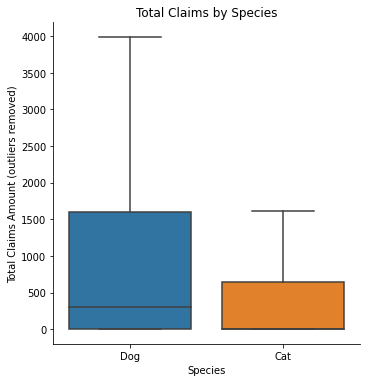

In [162]:
# Create boxplot showing the distribution of claims totals by species
sns.catplot(x="Species", y="AmtClaimsTotal", data=df, kind="box", sym="")
plt.ylabel("Total Claims Amount (outliers removed)")
plt.title("Total Claims by Species")
plt.show()

## Other species related analysis

In [17]:
cats = df[df.Species == 'Cat'].copy()
dogs = df[df.Species == 'Dog'].copy()

In [18]:
cats.AmtClaimsYr2.describe()

count     8024.000000
mean       444.637845
std       1933.711048
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      70251.600000
Name: AmtClaimsYr2, dtype: float64

In [19]:
dogs.AmtClaimsYr2.describe()

count    41976.000000
mean       739.179708
std       2294.107457
min          0.000000
25%          0.000000
50%          0.000000
75%        483.440000
max      58392.140000
Name: AmtClaimsYr2, dtype: float64

In [114]:
print("95% of cat claims in year 2 are below $" + str(int(cats.AmtClaimsYr2.quantile(0.95))))
print("95% of dog claims in year 2 are below $" + str(int(dogs.AmtClaimsYr2.quantile(0.95))))

95% of cat claims in year 2 are below $2314
95% of dog claims in year 2 are below $3816


## Review the cats data to see if there is a significant difference between different breeds or not

1. Also do the same for dogs and if the difference is significant, then consider pulling in additional data to allow for grouping by size or life expectancy

In [125]:
cats_by_breed = cats.groupby('Breed').agg({'NumClaimsTotal':['count', 'mean'], 
                         'AmtClaimsTotal':['mean', 'median', 'min', 'max']})
cats_by_breed

NumClaimsTotal            AmtClaimsTotal             \
                              count       mean           mean     median   
Breed                                                                      
Abyssinian                       24   4.250000    1462.780417    307.270   
American Bobtail                 10   0.600000     679.742000      0.000   
American Shorthair              402   1.611940     759.730473      0.000   
American Wirehair                 1   0.000000       0.000000      0.000   
Balinese                         22   3.090909    1892.429545    900.735   
Bengal                          146   1.883562    1231.746438      0.000   
Birman                           12   0.666667    1121.506667      0.000   
Bombay                            9   2.333333     330.781111      0.000   
British Longhair                  2   0.000000       0.000000      0.000   
British Shorthair                81   2.037037     855.749506    155.250   
Burmese                          20   2.200000     752.667500    178.705   
Chartreux                         1   0.000000       0.000000      0.000   
Chausie                           1   1.000000     331.740000    331.740   
Colorpoint Shorthair              2   4.000000    9806.425000   9806.425   
Cornish Rex                      11   1.818182     858.554545      0.000   
Devon Rex                        28   3.678571    1001.486071    210.460   
Domestic Longhair               385   2.212987    1240.163662      0.000   
Domestic Mediumhair             551   1.539020     746.456534      0.000   
Domestic Shorthair             3511   1.595842     776.121136      0.000   
Donskoy                          10   0.700000     581.072000      0.000   
Egyptian Mau                     10   1.000000     414.631000      0.000   
Exotic Longhair                   6   2.333333     798.573333    525.005   
Exotic Shorthair                 22   1.045455     510.223636      4.950   
Havana Brown                      1   2.000000    2342.530000   2342.530   
Himalayan                        43   2.534884    1301.920233    162.360   
Japanese Bobtail                  3   0.333333      34.903333      0.000   
Korat                             4   0.500000     271.515000      0.000   
LaPerm                            1   2.000000    4487.820000   4487.820   
Lykoi                             3   2.000000     344.080000    276.180   
Maine Coon                      171   2.298246    1537.849064    175.000   
Manx                             15   0.400000     199.462667      0.000   
Mixed Breed                    1541   1.621025     853.588689      0.000   
Munchkin                         10   2.100000     319.073000      0.000   
Nebelung                          3   0.000000       0.000000      0.000   
Norwegian Forest                 11   2.181818    1140.530909      0.000   
Ocicat                            4   1.750000     631.847500    605.660   
Oriental                         10   2.700000    1118.092000      0.000   
Persian                          89   2.303371    1190.896292      0.000   
Peterbald                         4   2.000000    1690.977500    426.275   
Pixiebob                         10   0.000000       0.000000      0.000   
Ragdoll                         194   2.340206    1131.709175      0.000   
Russian Blue                     65   1.538462     555.251077      0.000   
Savannah                         28   1.785714     970.495357     97.560   
Scottish Fold                    54   2.277778     864.882222      0.000   
Selkirk Rex                       1  26.000000   25578.190000  25578.190   
Siamese                         178   1.820225     976.035899      0.000   
Siberian                        120   1.875000    1058.904500      0.000   
Singapura                         5   1.800000    1028.936000    994.430   
Snowshoe                          9   2.111111    1727.441111      0.000   
Somali                            1   0.000000       0.000000      0.

In [ ]:
###########
# TODO
##########
# View distribution of average claims by cat breed (below seems like it would work for dogs as well)
## Maybe a scatter plot - each breed is a point plotted based on avg total num claims and avg total amount claims 
## Scatter plot circle size based on count of breed

# Remove outlier claims amounts
# Group cat breeds with fewer than 20 or 30 representative cats (unless it seems there is a significant difference maybe?? how to do this?)


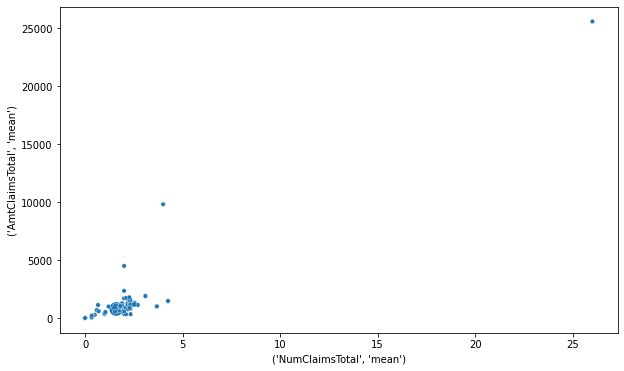

In [141]:
breed_counts = cats_by_breed['NumClaimsTotal', 'count']
breed_num_claims = cats_by_breed['NumClaimsTotal', 'mean']
breed_amt_claims = cats_by_breed['AmtClaimsTotal', 'mean']

plt.figure(figsize=(10,6))
_ = sns.scatterplot(data=cats_by_breed, x=breed_num_claims, y=breed_amt_claims, 
                    size=breed_counts, sizes=(20, 200), legend=False)
plt.show()

In [153]:
cats_by_breed = cats_by_breed[cats_by_breed['AmtClaimsTotal', 'mean'] < 2000]

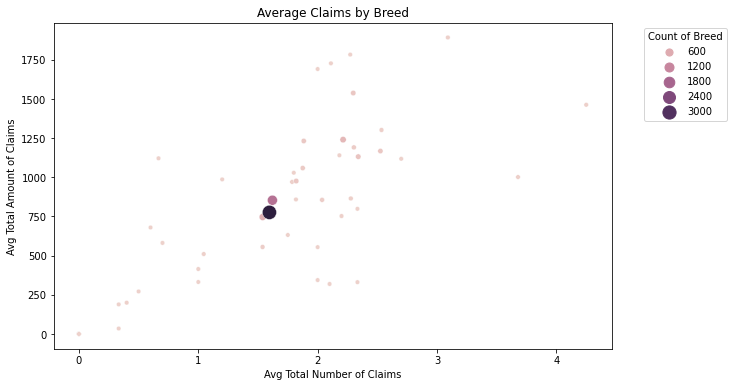

In [207]:
breed_counts = cats_by_breed['NumClaimsTotal', 'count']
breed_num_claims = cats_by_breed['NumClaimsTotal', 'mean']
breed_amt_claims = cats_by_breed['AmtClaimsTotal', 'mean']

plt.figure(figsize=(10,6))
_ = sns.scatterplot(data=cats_by_breed, x=breed_num_claims, y=breed_amt_claims, 
                    hue=breed_counts, size=breed_counts, sizes=(20, 200), legend=True)

plt.xlabel('Avg Total Number of Claims')
plt.ylabel('Avg Total Amount of Claims')
plt.title('Average Claims by Breed')
# _._legend.set_title('Count of Breed')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5, title="Count of Breed")

plt.show()

## Consider plotting the claims in year 1 and 2 after removing the outlier data to get a better distribution.

## Correlation between Yr2 claims and other features

In [34]:
cats_corr = cats.corr()
dogs_corr = dogs.corr()

In [52]:
cats_corr

,Premium,Deductible,AgeYr1,AgeYr2,YoungAge,MixedBreed,AmtClaimsYr1,AmtClaimsYr2,AvgClaimsYr1,AvgClaimsYr2,NumClaimsYr1,NumClaimsYr2,NumClaimsTotal,AmtClaimsTotal,AvgClaimsTotal
Premium,1.000000,-0.329189,0.462401,0.462401,-0.010162,-0.014634,0.098459,0.119203,0.089318,0.107789,0.099103,0.137941,0.141798,0.142778,0.109068
Deductible,-0.329189,1.000000,0.271772,0.271772,-0.029727,0.025892,-0.027339,-0.033331,-0.028875,-0.028030,-0.071139,-0.052148,-0.072593,-0.039815,-0.020840
AgeYr1,0.462401,0.271772,1.000000,1.000000,-0.050391,0.043772,0.040875,0.056472,0.050250,0.054367,0.023696,0.088482,0.068473,0.064402,0.058322
AgeYr2,0.462401,0.271772,1.000000,1.000000,-0.050391,0.043772,0.040875,0.056472,0.050250,0.054367,0.023696,0.088482,0.068473,0.064402,0.058322
YoungAge,-0.010162,-0.029727,-0.050391,-0.050391,1.000000,0.008479,0.006886,-0.003680,-0.007488,-0.004256,0.015547,0.006109,0.012572,0.001163,-0.008309
MixedBreed,-0.014634,0.025892,0.043772,0.043772,0.008479,1.000000,-0.008596,0.000568,0.003770,-0.001179,-0.017063,-0.005409,-0.012990,-0.004408,-0.002858
AmtClaimsYr1,0.098459,-0.027339,0.040875,0.040875,0.006886,-0.008596,1.000000,0.177116,0.682642,0.096761,0.673016,0.287061,0.558284,0.691297,0.449081
AmtClaimsYr2,0.119203,-0.033331,0.056472,0.056472,-0.003680,0.000568,0.177116,1.000000,0.101741,0.687651,0.177872,0.614115,0.482804,0.833587,0.494685
AvgClaimsYr1,0.089318,-0.028875,0.050250,0.050250,-0.007488,0.003770,0.682642,0.101741,1.000000,0.091968,0.301320,0.115635,0.241926,0.457837,0.662744
AvgClaimsYr2,0.107789,-0.028030,0.054367,0.054367,-0.004256,-0.001179,0.096761,0.687651,0.091968,1.000000,0.079470,0.297132,0.229883,0.559167,0.721391


Total and average claims are highly correlated with yr1 and yr2 totals and averages, respectively. This makes sense. Some additional areas for analysis include:

1. Investigate to see if high yr1 claims tend to lead to high yr2 claims, or if there is any connection. (correlation is only 0.177)

2. 

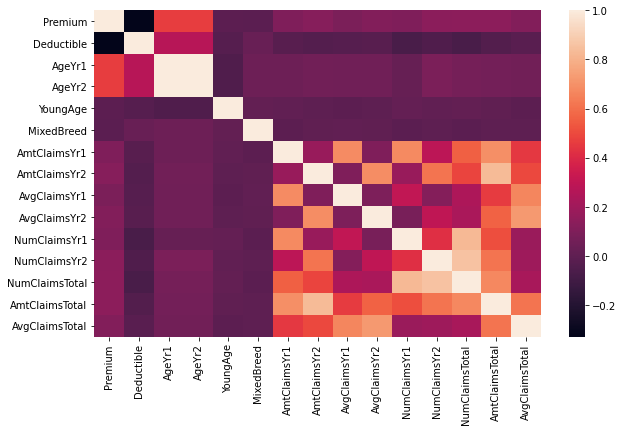

In [38]:
plt.figure(figsize=(10,6))
_ = sns.heatmap(cats_corr)
plt.show()

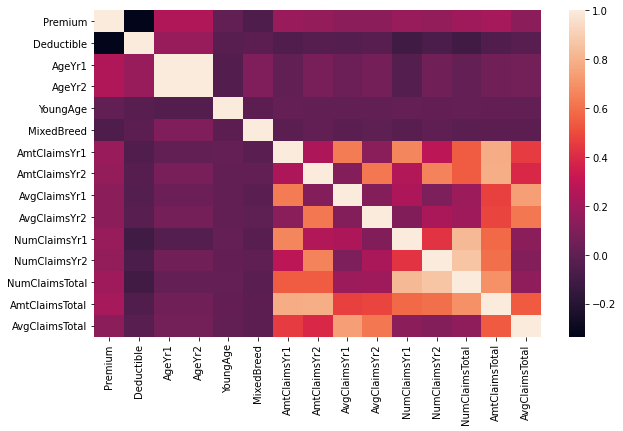

In [39]:
plt.figure(figsize=(10,6))
_ = sns.heatmap(dogs_corr)
plt.show()

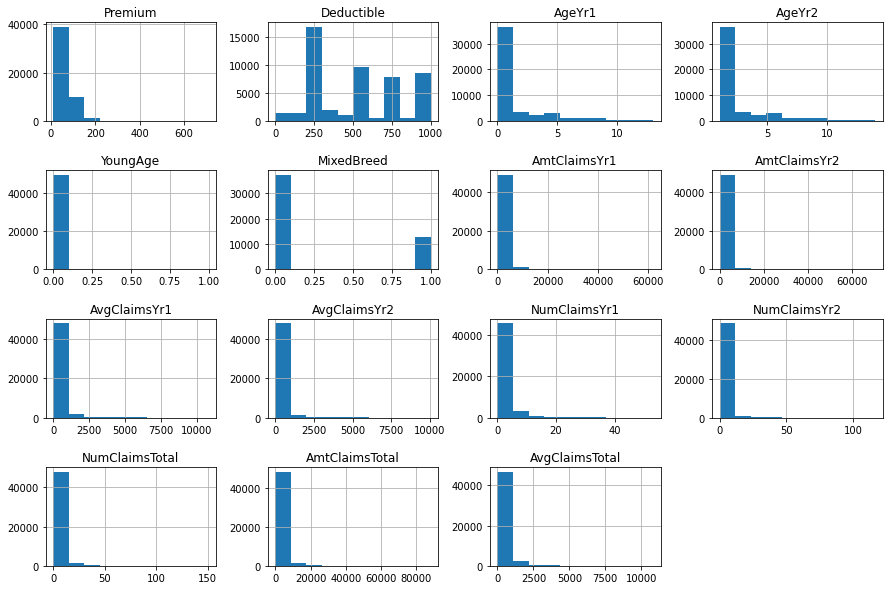

In [112]:
# Review Distributions of all numeric columns
df.hist(figsize=(15,10))
_ = plt.subplots_adjust(hspace=0.5)
plt.show()

## Are claims in year 1 a good predictor of claims in year 2? 

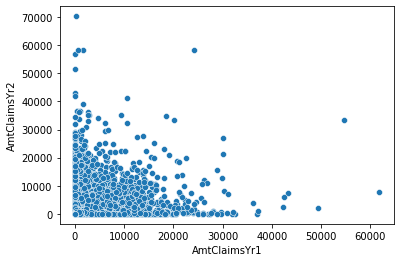

In [166]:
sns.scatterplot(x="AmtClaimsYr1", y="AmtClaimsYr2", data=df)
plt.show()

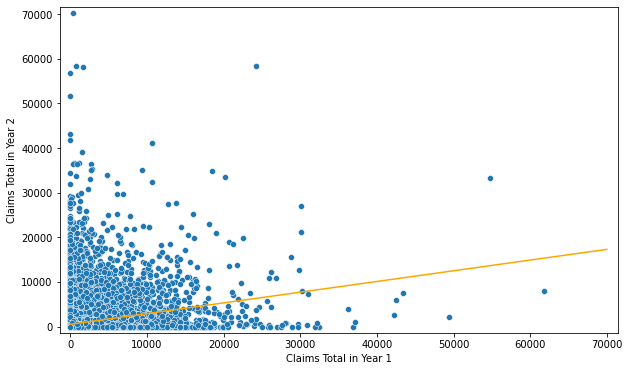

In [175]:
# Linear regression

# Create arrays of values
AmtClaimsYr1 = df.AmtClaimsYr1.values
AmtClaimsYr2 = df.AmtClaimsYr2.values

# Create the scatterplot
plt.figure(figsize=(10,6))
# _ = plt.plot(AmtClaimsYr1, AmtClaimsYr2, marker='.', linestyle='none')
sns.scatterplot(x="AmtClaimsYr1", y="AmtClaimsYr2", data=df)
plt.margins(0.02)
_ = plt.xlabel('Claims Total in Year 1')
_ = plt.ylabel('Claims Total in Year 2')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(AmtClaimsYr1, AmtClaimsYr2, 1)

# # Print the results to the screen
# print('slope =', a, 'Claims Total in Year 2 / Claims Total in Year 1')
# print('intercept =', b, 'Claims Total in Year 2')

# Make theoretical line to plot
x = np.array([0, 70000])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y, color='orange')

# Draw the plot
plt.show()

In [176]:
######
# TODO - Consider doing a similar plot as above for yr1 vs total and year2 vs total? Or a facet grid of all features
######

## What percentage of pets have no claims at all? Claims in year 1 and in year 2? Claims in only one of the two years?

In [193]:
# Calculate the percentages of pets with claims > $0 in 1 yr, 2 yrs and not at all 
no_claims = round(df[(df['AmtClaimsYr1'] == 0) & (df['AmtClaimsYr2'] == 0)].shape[0] / df.shape[0] * 100)
both_yr_claims = round(df[(df['AmtClaimsYr1'] > 0) & (df['AmtClaimsYr2'] > 0)].shape[0] / df.shape[0] * 100)
one_yr_claims = 100 - (no_claims + both_yr_claims)

# Print the result
print(str(no_claims) + "% of pets have no claims")
print(str(one_yr_claims) + "% of pets have claims in only one year")
print(str(both_yr_claims) + "% of pets have claims in both years")

45% of pets have no claims
33% of pets have claims in only one year
22% of pets have claims in both years


## Is there a connection between the number of claims submitted in year 1 and year 2?

## Breed analysis

In [68]:
# Groupby Breed column and aggregate the mean of the total claims amount
breed_claims = df.groupby(by=['Species', 'Breed']).AmtClaimsTotal.agg(['mean', 'count']).sort_values(by='mean',
                                                                                        ascending=False)
# Rename aggregate columns 
breed_claims.rename(columns={"mean": "AvgTotalClaims", "count": "BreedCount"}, inplace=True)

# Preview descriptive statistics 
breed_claims.describe()

,AvgTotalClaims,BreedCount
count,373.000000,373.000000
mean,1765.657092,134.048257
std,2435.361667,435.819051
min,0.000000,1.000000
25%,746.456534,4.000000
50%,1227.918333,14.000000
75%,1999.970244,73.000000
max,25578.190000,4653.000000


In [71]:
breed_claims.head(50)

AvgTotalClaims  BreedCount
Species Breed                                                 
Cat     Selkirk Rex                   25578.190000           1
Dog     Bergamasco Sheepdog           21981.270000           1
        Tibetan Mastiff               19668.195000           2
        Akbash Dog                    11383.600000           1
        American Mastiff              11064.570000           1
        St Johns Waterdog              9868.480000           1
Cat     Colorpoint Shorthair           9806.425000           2
Dog     Mi Ki                          7556.816667           6
        Perro de Presa Canario         7225.331429           7
        Dogue de Bordeaux              6343.498333          12
        Central Asian Shepherd         5870.580000           3
        Scottish Deerhound             5825.647500           4
        Clumber Spaniel                5779.530000           7
        Bantam Bulldog                 5438.790000           1
        Old Boston Bulldogge           5110.556667           6
        Anatolian Shepherd             5060.245714           7
        Miniature Bull Terrier         4949.283846          13
        Cirneco dell Etna              4855.720000           2
        Wirehair Vizsla                4498.066667           6
Cat     LaPerm                         4487.820000           1
Dog     Norfolk Terrier                4465.363333           3
        Kuvasz                         4449.356000           5
        Bull Terrier Standard          4403.142500           8
        Dingo Carolina                 4243.761667           6
        English Foxhound               4200.486667           3
        Black Russian Terrier          4139.972500           8
        Bloodhound                     3851.571538          26
        American Water Spaniel         3738.825000           4
        English Bulldog                3672.979688         481
        Olde English Bulldog           3641.280254         118
        Irish Wolfhound                3604.366610          59
        Flat Coated Retriever          3547.109118          34
        American Foxhound              3541.542857           7
        Glen of Imaal Terrier          3536.820000           1
        Mastiff                        3498.422308          26
        Beauceron                      3435.771429          14
        Newfoundland                   3422.989159         107
        American Bully                 3409.193191          47
        Shar Pei                       3294.443077          39
        Lakeland Terrier               3270.112000           5
        Polish Lowland Sheepdog        3264.488000           5
        Pointer                        3240.263478          23
        Komondor                       3179.650000           1
        Springer Spaniel               3134.781579          19
        Alaskan Malamute               3096.346719          64
        Hovawart                       3081.735000           2
        Finnish Lapphund               3012.030000           1
        Argentine Dogo                 3011.587333          15
        Greater Swiss Mountain Dog     2996.385000          40
        Malinois Belgian Shepherd      2946.804286           7

In [67]:
breed_claims.tail(20)

,AvgTotalClaims,BreedCount
Breed,,
Bavarian Mountain Hound,0.0,1
Canaan Dog,0.0,1
Caucasian Ovcharka,0.0,1
Australian Stumpy Tail Cattle,0.0,1
Cesky Terrier,0.0,2
Chartreux,0.0,1
Large Munsterlander,0.0,1
Chipoo,0.0,2
Pharaoh Hound,0.0,2


In [ ]:
cond_plot = sns.FacetGrid(data=cats, col='Breed', hue='CentralAir', col_wrap=4)
cond_plot.map(sns.scatterplot, 'OverallQual', 'SalePrice');

## EnrollPath - Do people who enroll on the web submit more claims on average than those enrolling by phone?

Does enrollpath matter in terms of number of claims filed?
Look at median claims

In [72]:
# Preview enroll path entries and value counts
df.EnrollPath.value_counts()

Web      25486
Phone    23525
EB         989
Name: EnrollPath, dtype: int64

In [84]:
# Group data by enrollpath
enrollpath = df.groupby(by='EnrollPath')

# Display aggregated statistics for total claims amount by enrollpath
enrollpath.NumClaimsTotal.agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
EnrollPath,,,,
EB,2.878665,1,0,99
Phone,3.405016,1,0,151
Web,2.822687,1,0,106


In [104]:
# Display aggregated statistics for total claims amount by enrollpath
enrollpath.AmtClaimsTotal.agg(['mean', 'median', 'min', 'max'])

,count,mean,median,min,max
EnrollPath,,,,,
EB,989,1661.101335,128.02,0.0,58967.35
Phone,23525,1583.704865,250.90,0.0,82643.03
Web,25486,1395.720871,194.07,0.0,88087.19


## How much does age play a roll in yr2 claims totals?
1. Look at average claims amount grouped by age in years
2. Scatterplot of AgeYr2 and AmtClaimsYr2 (maybe do this all up and also a facetgrid with a plot per year)
3. 

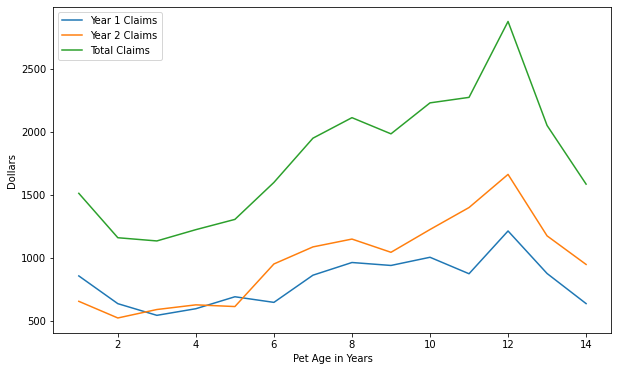

In [100]:
# Aggregate mean claims data per year and total
yr1_claims = df.groupby(by='AgeYr2').AmtClaimsYr1.agg('mean')
yr2_claims = df.groupby(by='AgeYr2').AmtClaimsYr2.agg('mean')
total_claims = df.groupby(by='AgeYr2').AmtClaimsTotal.agg('mean')

# Create plots and label
plt.figure(figsize=(10,6))
_ = plt.plot(yr1_claims, label='Year 1 Claims')
_ = plt.plot(yr2_claims, label='Year 2 Claims')
_ = plt.plot(total_claims, label='Total Claims')

plt.xlabel('Pet Age in Years')
plt.ylabel('Dollars')

plt.legend()
plt.show()

In [ ]:
# # Isolate rows with high premiums for additional review
# high_prems = pets[pets['Premium'] > 200]

# # Review date distribution
# plt.figure(figsize=(6, 4))
# plt.title('Distribution of High Premiums')
# plt.hist(high_prems.Premium, bins = 20)
# plt.show()

In [ ]:
# # Review the number of pets with high premiums by species
# high_prems.Species.value_counts()

In [ ]:
# Plotting a histogram
# Compute number of data points: n_data
n_data = len(versicolor_petal_length)

# Number of bins is the square root of number of data points: n_bins
n_bins = np.sqrt(n_data)

# Convert number of bins to integer: n_bins
n_bins = int(n_bins)

# Plot the histogram
_ = plt.hist(versicolor_petal_length, bins=n_bins)

# Label axes
_ = plt.xlabel('petal length (cm)')
_ = plt.ylabel('count')

# Show histogram
plt.show()

In [ ]:
# Plotting a beeswarm plot
# Create bee swarm plot with Seaborn's default settings
_ = sns.swarmplot(x='species', y='petal length (cm)', data=df)

# Label the axes
_ = plt.xlabel('species')
_ = plt.ylabel('petal length (cm)')

# Show the plot
plt.show()

In [ ]:
# ECDF function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [ ]:
# Compute and plot ECDF 

# Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(versicolor_petal_length)

# Generate plot
_ = plt.plot(x_vers, y_vers, marker='.', linestyle='none')

# Label the axes
_ = plt.xlabel('petal length (cm)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.show()

In [ ]:
# Comparison of ECDFs

# Compute ECDFs
x_set, y_set = ecdf(setosa_petal_length)
x_vers, y_vers = ecdf(versicolor_petal_length)
x_virg, y_virg = ecdf(virginica_petal_length)

# Plot all ECDFs on the same plot
_ = plt.plot(x_set, y_set, marker='.', linestyle='none')
_ = plt.plot(x_vers, y_vers, marker='.',linestyle='none')
_ = plt.plot(x_virg, y_virg, marker='.',linestyle='none')

# Annotate the plot
plt.legend(('setosa', 'versicolor', 'virginica'), loc='lower right')
_ = plt.xlabel('petal length (cm)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.show()

In [ ]:
# Comparing percentiles to ECDFs

# Compute percentiles

# Specify array of percentiles: percentiles
percentiles = np.array([2.5, 25,50,75, 97.5])

# Compute percentiles: ptiles_vers
ptiles_vers = np.percentile(versicolor_petal_length, percentiles)

# Print the result
print(ptiles_vers)

# Plot the ECDF
_ = plt.plot(x_vers, y_vers, '.')
_ = plt.xlabel('petal length (cm)')
_ = plt.ylabel('ECDF')

# Overlay percentiles as red diamonds.
_ = plt.plot(ptiles_vers, percentiles/100, marker='D', color='red',
         linestyle='none')

# Show the plot
plt.show()

In [ ]:
# Compare ditribution of feature with normal distribution

# Compute mean and standard deviation: mu, sigma
mu = np.mean(belmont_no_outliers)
sigma = np.std(belmont_no_outliers)

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(belmont_no_outliers)

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.xlabel('Belmont winning time (sec.)')
_ = plt.ylabel('CDF')
plt.show()

In [ ]:
# Linear regression

# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(illiteracy, fertility, 1)

# Print the results to the screen
print('slope =', a, 'children per woman / percent illiterate')
print('intercept =', b, 'children per woman')

# Make theoretical line to plot
x = np.array([0, 100])
y = a * x + b

# Add regression line to your plot
_ = plt.plot(x, y)

# Draw the plot
plt.show()

In [ ]:
# Plotting bootstrap samples

for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, marker='.')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

# Show the plot
plt.show()

In [ ]:
# Function to generate bootstrap replicates
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.mean, 10000)

# Compute and print SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

In [ ]:
# Pairs bootstrap

# Function
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(illiteracy, fertility, size=1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps,[2.5, 97.5]))

# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50, normed=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
plt.show()

# Generate array of x-values for bootstrap lines: x
x = np.array([0,100])

# Plot the bootstrap lines
for i in range(0,100):
    _ = plt.plot(x, 
                 bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)
plt.show()

In [ ]:
# Permutation Sampling

# Function
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

# Visualizing permutation sampling

for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june, rain_november)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_june)
x_2, y_2 = ecdf(rain_november)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('monthly rainfall (mm)')
_ = plt.ylabel('ECDF')
plt.show()



In [ ]:
# Generating permutation replicates

# Function
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

# EDA prior to hypothesis testing

# Make bee swarm plot
_ = sns.swarmplot(x="ID", y="impact_force", data=df)

# Label axes
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

# Show the plot
plt.show()


# Permutation test
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

In [ ]:
# One sample bootstrap hypothesis test

# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 0.55

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean , 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)

# Two Sample bootstrap hypothesis test

# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, 10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)